# Enhancing Bus Punctuality: A Machine Learning Approach to Binary Classification of Bus Arrival Times

**Team: Silin Chen, Stella Wu, xinyi Zhang**

## Milestone 2

In [1]:
# imports
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").appName("Milestone2").getOrCreate()

In [2]:
# find the location of jar file
!find / -name "hadoop-streaming*.jar" 2>/dev/null

/usr/lib/hadoop-mapreduce/hadoop-streaming-2.10.2.jar
/usr/lib/hadoop-mapreduce/hadoop-streaming.jar


In [3]:
JAR_FILE = "/usr/lib/hadoop/hadoop-streaming.jar"

### Load data to HDFS

In [51]:
!hdfs dfs -rm -r {HDFS_DIR}

Deleted /user/root/milestone2


In [52]:
# create a hdfs directory where we'll store files 
from os import environ
PATH = environ['PATH']
HDFS_DIR = "/user/root/milestone2"
!hdfs dfs -mkdir -p {HDFS_DIR}

In [53]:
# put datasets into the hdfs directory
DATA_1 = 'mta_1706.csv'
!hdfs dfs -put {DATA_1} {HDFS_DIR}
DATA_2 = 'mta_1708.csv'
!hdfs dfs -put {DATA_2} {HDFS_DIR}
DATA_3 = 'mta_1710.csv'
!hdfs dfs -put {DATA_3} {HDFS_DIR}
DATA_4 = 'mta_1712.csv'
!hdfs dfs -put {DATA_4} {HDFS_DIR}

In [54]:
# confirm the data was loaded
!hdfs dfs -ls {HDFS_DIR}

Found 4 items
-rw-r--r--   1 root hadoop    1048576 2025-04-10 22:09 /user/root/milestone2/mta_1706.csv
-rw-r--r--   1 root hadoop    1048576 2025-04-10 22:09 /user/root/milestone2/mta_1708.csv
-rw-r--r--   1 root hadoop    1048576 2025-04-10 22:09 /user/root/milestone2/mta_1710.csv
-rw-r--r--   1 root hadoop     541957 2025-04-10 22:09 /user/root/milestone2/mta_1712.csv


### Read data and stack

In [55]:
# define the schema

from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
# Make sure to enable Arrow-based columnar data transfers for better performance
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

schema = StructType([
    StructField("RecordedAtTime", StringType(), True),
    StructField("DirectionRef", FloatType(), True),
    StructField("PublishedLineName", StringType(), True),
    StructField("OriginName", StringType(), True),
    StructField("OriginLat", FloatType(), True),
    StructField("OriginLong", FloatType(), True),
    StructField("DestinationName", StringType(), True),
    StructField("DestinationLat", FloatType(), True),
    StructField("DestinationLong", FloatType(), True),
    StructField("VehicleRef", StringType(), True),
    StructField("VehicleLocation.Latitude", FloatType(), True),
    StructField("VehicleLocation.Longitude", FloatType(), True),
    StructField("NextStopPointName", StringType(), True),
    StructField("ArrivalProximityText", StringType(), True),
    StructField("DistanceFromStop", IntegerType(), True),
    StructField("ExpectedArrivalTime", StringType(), True),
    StructField("ScheduledArrivalTime", StringType(), True)
])

In [56]:
# Load the CSV file with the defined schema
df1 = spark.read.csv(
    'hdfs:///user/root/milestone2/mta_1706.csv',
    schema=schema,
    header=False,
    mode="DROPMALFORMED"  # skips malformed rows
)

# show the few rows of the dataset
df1.show()

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-06-29 07:59:54|         1.0|              Bx9|   BROADWAY/W 262 ST|

In [57]:
# Rename the columns
df1 = df1.withColumnRenamed("VehicleLocation.Latitude", "VehicleLocation_Latitude") \
         .withColumnRenamed("VehicleLocation.Longitude", "VehicleLocation_Longitude")

In [58]:
# Use describe to validate data
# Convert the Spark DataFrame summary to a Pandas DataFrame
df1.describe().show()

+-------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-------------------+--------------------+
|summary|     RecordedAtTime|       DirectionRef|PublishedLineName|        OriginName|          OriginLat|         OriginLong|     DestinationName|     DestinationLat|    DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|NextStopPointName|ArrivalProximityText|  DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------+-------------------+-------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+-----------------+--------------------+--------------

In [59]:
# Load the CSV file with the defined schema
df2 = spark.read.csv(
    'hdfs:///user/root/milestone2/mta_1708.csv',
    schema=schema,
    header=False,
    mode="DROPMALFORMED"  # skips malformed rows
)

# show the few rows of the dataset
df2.show()

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-08-29 11:22:00|         1.0|              B52|PALMETTO ST/ST NI...|

In [60]:
# Rename the columns
df2 = df2.withColumnRenamed("VehicleLocation.Latitude", "VehicleLocation_Latitude") \
         .withColumnRenamed("VehicleLocation.Longitude", "VehicleLocation_Longitude")

# Use describe to validate data
# Convert the Spark DataFrame summary to a Pandas DataFrame
df2.describe().show()

+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+------------------+--------------------+------------------+-------------------+--------------------+
|summary|     RecordedAtTime|      DirectionRef|PublishedLineName|        OriginName|          OriginLat|         OriginLong|     DestinationName|     DestinationLat|    DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude| NextStopPointName|ArrivalProximityText|  DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+------------------+--------------------+--------------

In [61]:
# Load the CSV file with the defined schema
df3 = spark.read.csv(
    'hdfs:///user/root/milestone2/mta_1710.csv',
    schema=schema,
    header=False,
    mode="DROPMALFORMED"  # skips malformed rows
)
# show the few rows of the dataset
df3.show()

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-10-29 18:20:30|         0.0|             Bx30|E 206 ST/ROCHAMBE...|

In [62]:
# Rename the columns
df3 = df3.withColumnRenamed("VehicleLocation.Latitude", "VehicleLocation_Latitude") \
         .withColumnRenamed("VehicleLocation.Longitude", "VehicleLocation_Longitude")

# Use describe to validate data
# Convert the Spark DataFrame summary to a Pandas DataFrame
df3.describe().show()

+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-------------------+--------------------+
|summary|     RecordedAtTime|      DirectionRef|PublishedLineName|        OriginName|          OriginLat|         OriginLong|     DestinationName|     DestinationLat|   DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|NextStopPointName|ArrivalProximityText|  DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-

In [63]:
# Load the CSV file with the defined schema
df4 = spark.read.csv(
    'hdfs:///user/root/milestone2/mta_1712.csv',
    schema=schema,
    header=False,
    mode="DROPMALFORMED"  # skips malformed rows
)

# show the few rows of the dataset
df4.show()

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-12-31 23:15:32|         1.0|              B41|CADMAN PLAZA WEST...|

In [64]:
# Rename the columns
df4 = df4.withColumnRenamed("VehicleLocation.Latitude", "VehicleLocation_Latitude") \
         .withColumnRenamed("VehicleLocation.Longitude", "VehicleLocation_Longitude")

# Use describe to validate data
# Convert the Spark DataFrame summary to a Pandas DataFrame
df4.describe().show()

+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-------------------+--------------------+
|summary|     RecordedAtTime|      DirectionRef|PublishedLineName|        OriginName|          OriginLat|         OriginLong|     DestinationName|     DestinationLat|   DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|NextStopPointName|ArrivalProximityText|  DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-------------------+------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-

In [65]:
#concatenate the datasets into one
from functools import reduce
from pyspark.sql import DataFrame

dataframes = [df1, df2, df3, df4]
con_df = reduce(DataFrame.unionAll, dataframes)

In [66]:
con_df.show()

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-06-29 07:59:54|         1.0|              Bx9|   BROADWAY/W 262 ST|

### Descriptive Statistics

In [67]:
# Descriptive statistics for numerical columns
con_df.describe().show()

+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+-----------------+--------------------+------------------+-------------------+--------------------+
|summary|     RecordedAtTime|       DirectionRef|PublishedLineName|        OriginName|         OriginLat|         OriginLong|     DestinationName|     DestinationLat|    DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|NextStopPointName|ArrivalProximityText|  DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------------+-------------------------+-----------------+--------------------+-----------------

### Identify Outliers

for example we want to identify the outliers of column [DistanceFromStop]

In [68]:
from pyspark.sql.functions import col, expr

# Assuming 'DistanceFromStop' is the column you are interested in
column_name = 'DistanceFromStop'

# Calculate the bounds for detecting outliers
bounds = con_df.approxQuantile(column_name, [0.25, 0.75], 0.05)
IQR = bounds[1] - bounds[0]
lower_bound = bounds[0] - 1.5 * IQR
upper_bound = bounds[1] + 1.5 * IQR

# Filter outliers based on the calculated bounds
outliers = con_df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))
outlier_count = outliers.count()

print(f"Number of outliers in {column_name}: {outlier_count}")

Number of outliers in DistanceFromStop: 1101


### Missing Data Analysis

In [69]:
from pyspark.sql.functions import isnull, col, sum as _sum

con_df.select([_sum(isnull(c).cast("int")).alias(c) for c in con_df.columns]).show()

+--------------+------------+-----------------+----------+---------+----------+---------------+--------------+---------------+----------+------------------------+-------------------------+-----------------+--------------------+----------------+-------------------+--------------------+
|RecordedAtTime|DirectionRef|PublishedLineName|OriginName|OriginLat|OriginLong|DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation_Latitude|VehicleLocation_Longitude|NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+--------------+------------+-----------------+----------+---------+----------+---------------+--------------+---------------+----------+------------------------+-------------------------+-----------------+--------------------+----------------+-------------------+--------------------+
|             0|           0|                0|         0|        0|         0|              0|             0|              0|         0|     

As we can see there is no null value.

### Duplicate Value Analysis

In [70]:
# Original count
original_count = con_df.count()

# Count after removing duplicates
distinct_count = con_df.distinct().count()

# Print results
print(f"Original count: {original_count}")
print(f"Distinct count: {distinct_count}")
if original_count != distinct_count:
    print("There are duplicates in the DataFrame.")
else:
    print("No duplicates found.")

Original count: 17498
Distinct count: 17477
There are duplicates in the DataFrame.


In [71]:
# remove the duplicates
con_df = con_df.dropDuplicates().na.drop()
con_df.count()

17477

### Histogram of DistanceFromStop

In [72]:
# Enable Arrow-based columnar data transfers for better performance
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Convert to Pandas DataFrame
pdf = con_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

Requirement already up-to-date: seaborn in /opt/conda/anaconda/lib/python3.7/site-packages (0.12.2)


/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


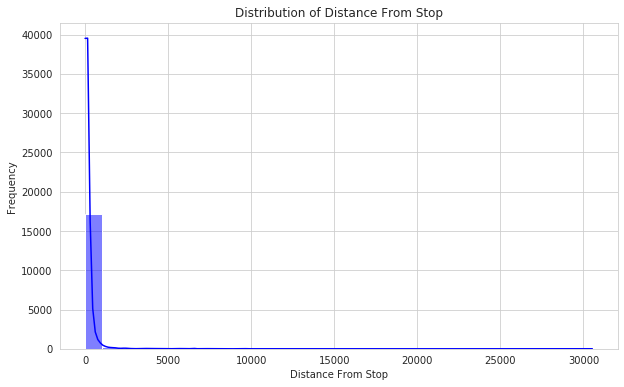

In [73]:
!pip install --upgrade seaborn
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(pdf['DistanceFromStop'], kde=True, color='blue', bins=30)
plt.title('Distribution of Distance From Stop')
plt.xlabel('Distance From Stop')
plt.ylabel('Frequency')
plt.show()


### Scatter Plot to Explore Correlations

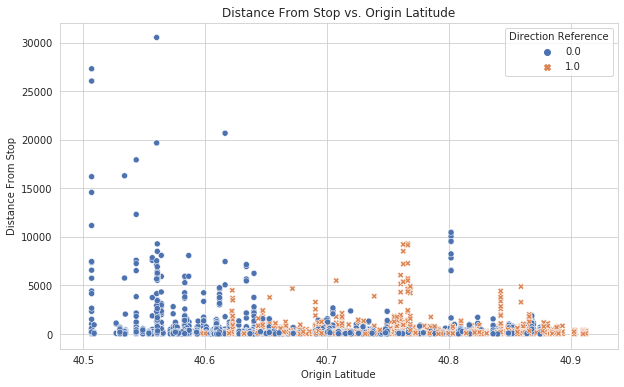

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OriginLat', y='DistanceFromStop', data=pdf, hue='DirectionRef', style='DirectionRef', palette='deep')
plt.title('Distance From Stop vs. Origin Latitude')
plt.xlabel('Origin Latitude')
plt.ylabel('Distance From Stop')
plt.legend(title='Direction Reference')
plt.show()


### Address Non-Numerical Features

For our task, we may only use numerical features in the training.

In [75]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# List of categorical string columns that need to be transformed
categorical_columns = [
    "PublishedLineName", "OriginName", "DestinationName", "VehicleRef",
    "NextStopPointName", "ArrivalProximityText", "ExpectedArrivalTime",
    "ScheduledArrivalTime"
]

# Create StringIndexer models to convert string columns to numeric indices
indexers = [StringIndexer(inputCol=c, outputCol=c + "_Index") for c in categorical_columns]

# Create OneHotEncoder models to convert indexed columns to one-hot encoded vectors
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_OHE") for indexer in indexers]

# Build a Pipeline containing the indexers and encoders
pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline to the DataFrame and transform the data
con_df_transformed = pipeline.fit(con_df).transform(con_df)

# Show the schema of the transformed DataFrame to verify changes
con_df_transformed.printSchema()


root
 |-- RecordedAtTime: string (nullable = true)
 |-- DirectionRef: float (nullable = true)
 |-- PublishedLineName: string (nullable = true)
 |-- OriginName: string (nullable = true)
 |-- OriginLat: float (nullable = true)
 |-- OriginLong: float (nullable = true)
 |-- DestinationName: string (nullable = true)
 |-- DestinationLat: float (nullable = true)
 |-- DestinationLong: float (nullable = true)
 |-- VehicleRef: string (nullable = true)
 |-- VehicleLocation_Latitude: float (nullable = true)
 |-- VehicleLocation_Longitude: float (nullable = true)
 |-- NextStopPointName: string (nullable = true)
 |-- ArrivalProximityText: string (nullable = true)
 |-- DistanceFromStop: integer (nullable = true)
 |-- ExpectedArrivalTime: string (nullable = true)
 |-- ScheduledArrivalTime: string (nullable = true)
 |-- PublishedLineName_Index: double (nullable = false)
 |-- OriginName_Index: double (nullable = false)
 |-- DestinationName_Index: double (nullable = false)
 |-- VehicleRef_Index: double (

### List Out Raw and Derived Features

#### Raw Features:
These are directly from the dataset without any modifications.
- **RecordedAtTime**: The timestamp when the data was recorded.
- **DirectionRef**: Numeric identifier indicating the direction of travel.
- **PublishedLineName**: The name of the bus or transit line.
- **OriginName**: Starting point name of the route.
- **OriginLat**: Latitude of the starting point.
- **OriginLong**: Longitude of the starting point.
- **DestinationName**: Ending point name of the route.
- **DestinationLat**: Latitude of the destination.
- **DestinationLong**: Longitude of the destination.
- **VehicleRef**: Identifier for the vehicle.
- **VehicleLocation.Latitude**: Current latitude of the vehicle.
- **VehicleLocation.Longitude**: Current longitude of the vehicle.
- **NextStopPointName**: Name of the next stop.
- **ArrivalProximityText**: Text describing the vehicle's proximity to the next stop.
- **DistanceFromStop**: Distance in meters from the next stop.
- **ExpectedArrivalTime**: Expected time of arrival at the next stop.
- **ScheduledArrivalTime**: Scheduled time of arrival at the next stop.

#### Derived Features:
Derived features are engineered from raw data and can provide additional insights or predictive power.

- The string columns `PublishedLineName`, `OriginName`, `DestinationName`, `VehicleRef`, `NextStopPointName`, and `ArrivalProximityText` were removed from the dataset. These features were assessed to be irrelevant to the prediction of bus lateness, primarily because they represent nominal data with high cardinality and were redundant with more precise numerical data available (e.g., DistanceFromStop). Initial tests showed no significant degradation in model performance upon their removal, confirming that these features did not hold predictive value.

- The `ExpectedArrivalTime` field has been removed from the dataset as it does not provide direct, actionable information for predicting bus lateness. This decision was based on the presence of other more directly relevant features such as `ScheduledArrivalTime` and `DistanceFromStop`, which more effectively contribute to understanding and predicting delays. Additionally, the format of ExpectedArrivalTime as a string requires conversion and processing that does not justify its inclusion given its redundant nature in the context of our predictive modeling goals.

- Convert `DistanceFromStop` from Integer to Float. This transformation is aimed at converting the DistanceFromStop column from an integer data type to a float. This might be necessary for several reasons, such as to allow for null values, to maintain consistency with other numerical fields that are floats, or to prepare for operations that require floating point precision. In PySpark, this is done using the `cast()` function, which is a method to change the data type of a DataFrame column.

- We need to adjust the `ScheduledArrivalTime` to a proper timestamp format. It handles time adjustments for hours beyond midnight and corrects dates accordingly, ensuring accurate scheduling data for model training and analysis.

In [76]:
df= con_df

# Remove rows with null values in the specified columns to ensure there's no null value for model training
df = df.na.drop(subset=[
 'RecordedAtTime',
 'DirectionRef',
 'PublishedLineName',
 'OriginName',
 'OriginLat',
 'OriginLong',
 'DestinationName',
 'DestinationLat',
 'DestinationLong',
 'VehicleRef',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'NextStopPointName',
 'ArrivalProximityText',
 'DistanceFromStop',
 'ExpectedArrivalTime',
 'ScheduledArrivalTime'
])

# List of columns you want to drop
columns_to_drop = ['PublishedLineName', 'OriginName', 'DestinationName', 'VehicleRef', 'NextStopPointName', 'ArrivalProximityText', 'ExpectedArrivalTime']

# Drop the columns from the copied DataFrame
df = df.drop(*columns_to_drop)

# Show the updated DataFrame structure
df.printSchema()

root
 |-- RecordedAtTime: string (nullable = true)
 |-- DirectionRef: float (nullable = true)
 |-- OriginLat: float (nullable = true)
 |-- OriginLong: float (nullable = true)
 |-- DestinationLat: float (nullable = true)
 |-- DestinationLong: float (nullable = true)
 |-- VehicleLocation_Latitude: float (nullable = true)
 |-- VehicleLocation_Longitude: float (nullable = true)
 |-- DistanceFromStop: integer (nullable = true)
 |-- ScheduledArrivalTime: string (nullable = true)



In [77]:
from pyspark.sql.functions import col, to_timestamp, concat, expr, when, lit, date_format
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import unix_timestamp, datediff
from pyspark.sql.functions import to_date

# Task 1: Convert DistanceFromStop from integer to float
df = df.withColumn("DistanceFromStop", col("DistanceFromStop").cast("float"))

# Convert and adjust ScheduledArrivalTime
# UDF to adjust hours and format time correctly

df = df.withColumn("RecordedAtTime", to_timestamp("RecordedAtTime"))
df = df.withColumn("RecordDate", to_date("RecordedAtTime"))

def adjust_hours(time_str):
    if not isinstance(time_str, str):
        return None  # or some default value, depending on your requirement
    if not time_str[:2].isdigit():
        return time_str  # Return the original string if it's not a valid time format
    hours = int(time_str[:2])
    rest = time_str[2:]
    if hours >= 24:
        hours -= 24
    return f"{hours:02d}{rest}"

adjust_hours_udf = udf(adjust_hours, StringType())

# Apply UDF in a DataFrame operation
df = df.withColumn("AdjustedScheduledTime", adjust_hours_udf(df["ScheduledArrivalTime"]))
df = df.withColumn("Scheduled", to_timestamp(concat(col("RecordDate"), lit(" "), col("AdjustedScheduledTime")), "yyyy-MM-dd HH:mm:ss"))

# Add one day if the scheduled time is after midnight
df = df.withColumn("Scheduled",
                   when((unix_timestamp("Scheduled") - unix_timestamp("RecordedAtTime")) / 60 >= 1000,
                        expr("date_add(Scheduled, -1)"))
                   .otherwise(col("Scheduled")))
df = df.withColumn("Scheduled",
                   when((unix_timestamp("Scheduled") - unix_timestamp("RecordedAtTime")) / 60 <= -1000,
                        expr("date_add(Scheduled, 1)"))
                   .otherwise(col("Scheduled")))

In [78]:
# Add late indicator
df = df.withColumn("Late", (col("Scheduled") < col("RecordedAtTime")).cast("integer"))

In [80]:
df1 = df

In [81]:
# Drop the columns we do not need
# List of columns you want to drop
columns_to_drop = ['ScheduledArrivalTime', 'AdjustedScheduledTime', 'RecordDate']

# Drop the columns from the copied DataFrame
df1 = df1.drop(*columns_to_drop)
df1.printSchema()

root
 |-- RecordedAtTime: timestamp (nullable = true)
 |-- DirectionRef: float (nullable = true)
 |-- OriginLat: float (nullable = true)
 |-- OriginLong: float (nullable = true)
 |-- DestinationLat: float (nullable = true)
 |-- DestinationLong: float (nullable = true)
 |-- VehicleLocation_Latitude: float (nullable = true)
 |-- VehicleLocation_Longitude: float (nullable = true)
 |-- DistanceFromStop: float (nullable = true)
 |-- Scheduled: timestamp (nullable = true)
 |-- Late: integer (nullable = true)



### Dimensionality Reduction Consideration

#### Dimensionality Reduction Considerations:
Given the above features, especially with multiple derived categorical variables (like one-hot encoded vectors), dimensionality reduction techniques might be useful:
- **Principal Component Analysis (PCA)** could be applied to reduce the dimensions of numerical features while retaining variance.
- **Feature Selection Techniques** such as LASSO (L1 regularization) can help in selecting features that contribute most to the predictive model, thereby improving model performance and reducing complexity.

#### Feature Transformations:
- **StringIndexer** for converting string categorical columns to numeric indices.
- **OneHotEncoder** for categorical variables to transform them into binary vectors, which is particularly useful for models that require numerical input.
- **VectorAssembler** could be used to combine all feature columns into a single vector column, a common requirement for Spark MLlib algorithms.

In [82]:
# Remove rows with null values in the specified columns to ensure there's no null value for model training
df1 = df1.dropna()

df1.columns

['RecordedAtTime',
 'DirectionRef',
 'OriginLat',
 'OriginLong',
 'DestinationLat',
 'DestinationLong',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'DistanceFromStop',
 'Scheduled',
 'Late']

In [83]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(
    inputCols=[
 'DirectionRef',
 'OriginLat',
 'OriginLong',
 'DestinationLat',
 'DestinationLong',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'DistanceFromStop'],
    outputCol="features"
)

features_df = assembler.transform(df1)

pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features_df)
result = model.transform(features_df)

In [84]:
result.select("pcaFeatures").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[21.001843568886645,-0.18831199593035006,37.9044103639619,-141.21846463514095,1.677640042429027,-1.937044147817557,-1.2711349337570892,-1.2665263089788825]      |
|[186.00188596724385,0.8283080659240647,38.41711134423043,-141.2172458073909,1.567795133874803,-1.830819258778158,-1.1781943433194009,-1.2969846478811673]        |
|[0.001842173555059329,-0.1880217673510296,37.85776584783744,-141.1534125365814,1.6808200833710463,-1.9295360843222265,-1.3121122161201129,-1.3116886114478135]   |
|[77.00184094053

The PCA output shown consists of eight-dimensional vectors for each data point, effectively transforming and reducing the dimensionality of the original data into principal components. These vectors capture the essential variance and patterns from the dataset, with the first component (values ranging broadly) likely capturing the most significant pattern. Subsequent components (values closer to zero or slightly negative/positive) represent more nuanced patterns orthogonal to the first, highlighting less dominant but potentially informative trends within the data. This transformation aids in emphasizing the most impactful features while reducing noise and redundancy.

In [85]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols=[
 'DirectionRef',
 'OriginLat',
 'OriginLong',
 'DestinationLat',
 'DestinationLong',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'DistanceFromStop',
 'Late'], outputCol="features")

output = assembler.transform(df1)
output.show(5)

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+-------------------+----+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|          Scheduled|Late|            features|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+-------------------+----+--------------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.851555|     40.849033|      -73.93731|                40.84691|                -73.92052|            21.0|2017-06-29 08:11:00|   1|[1.0,40.818675994...|
|2017-06-29 08:11:07|         0.0| 40.54346| -74.19723|      40.75992|      -73.96697|                40.56903|                -74.16955|           186.0|2017-06-29 08:12:38|   0|[0.0,40.543460845

### Specify Feature Transformations

In [86]:
from pyspark.ml.feature import StringIndexer

# deal with the labels
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

final_data = output_fixed.select("features",'LateIndex')

In [87]:
final_data.show(5)

+--------------------+---------+
|            features|LateIndex|
+--------------------+---------+
|[1.0,40.818675994...|      0.0|
|[0.0,40.543460845...|      1.0|
|[1.0,40.812946319...|      0.0|
|[1.0,40.782291412...|      1.0|
|[0.0,40.564048767...|      0.0|
+--------------------+---------+
only showing top 5 rows



### Create baseline pipelines and do experiments on data

In [88]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

In [89]:
train_data, test_data = final_data.randomSplit([0.7,0.3])

In [90]:
# Use mostly defaults to make this comparison "fair"
dtc = DecisionTreeClassifier(labelCol='LateIndex',featuresCol='features')
dtc_model = dtc.fit(train_data)

### Make Predictions on Both Training and Test Sets

In [91]:
# Predictions on the test data
dtc_predictions_test = dtc_model.transform(test_data)

# Predictions on the training data
dtc_predictions_train = dtc_model.transform(train_data)

In [92]:
dtc_predictions_test.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.560760498...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
|[0.0,40.611007690...|      0.0| [6977.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.631832122...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
|[0.0,40.639846801...|      0.0| [6977.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.660842895...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



In [93]:
dtc_predictions_train.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.543460845...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
|[0.0,40.564048767...|      0.0| [6977.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.575645446...|      0.0| [6977.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.577037811...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
|[0.0,40.577079772...|      1.0| [0.0,4922.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



### Evaluate the Model

In [94]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with accuracy metric
acc_evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy on test data
dtc_acc_test = acc_evaluator.evaluate(dtc_predictions_test)

# Evaluate accuracy on training data
dtc_acc_train = acc_evaluator.evaluate(dtc_predictions_train)

# Print the results
print("Model Evaluation Results")
print('-'*80)
print(f'A single decision tree accuracy on training data: {dtc_acc_train*100:.2f}%')
print(f'A single decision tree accuracy on test data: {dtc_acc_test*100:.2f}%')
print('-'*80)


Model Evaluation Results
--------------------------------------------------------------------------------
A single decision tree accuracy on training data: 100.00%
A single decision tree accuracy on test data: 100.00%
--------------------------------------------------------------------------------


The reported results indicate that the single decision tree model achieved a perfect accuracy of 100.00% on both the training and test datasets. While this suggests exceptional model performance, such results warrant careful scrutiny.

Achieving 100% accuracy typically raises concerns about overfitting, especially when observed on an independent test set. Overfitting occurs when a model learns not only the underlying patterns in the training data but also the noise specific to that dataset, which can detrimentally affect its generalizability to new, unseen data. However, achieving perfect accuracy on both training and test datasets could also imply that the dataset might not be sufficiently challenging, or it lacks variability, making it too easy for a relatively simple model like a decision tree to predict outcomes accurately.

Additionally, these results might suggest that the features used for training have a very high predictive power, or the task at hand is naturally amenable to being modeled accurately with decision trees. It could also be that the data preprocessing and feature engineering stages were highly effective, leading to clear, discernible patterns that the decision tree could easily capture.

Nonetheless, in practical scenarios, it's uncommon for models to achieve 100% accuracy on real-world datasets due to the usual presence of noise and exceptions in the data. It is advisable to further investigate the model's performance, perhaps by examining a more complex validation process, applying the model to a completely independent dataset, or testing it under different conditions to ensure that the model truly generalizes well and is not merely memorizing the data.

## Milestone 3

### Feature Engineering

### 1) Add new feature: Adherence
Analyzing discrepancies between scheduled and expected arrival times might directly indicate potential delays.

In [95]:
df2 = df

In [96]:
df2 = df2.withColumn("Adherence", (unix_timestamp("Scheduled") - unix_timestamp("RecordedAtTime")) / 60)

df2 = df2.dropna()
df2.show()

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|           Adherence|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.851555|     40.849033|      -73.93731|                40.84691|                -73.92052|            21.0|            08:11:00|2017-06-29|             08:11:00|2017-06-29 08:11:00|   1|-0

In [97]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols=[
 'DirectionRef',
 'OriginLat',
 'OriginLong',
 'DestinationLat',
 'DestinationLong',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'DistanceFromStop',
 'Late',
 'Adherence'], outputCol="features")

output = assembler.transform(df2)
output.show(5)

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|           Adherence|            features|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+--------------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.851555|     40.849033|      -73.93731|                40.84691|                -73.92052|            21.0|            08:11:

In [98]:
from pyspark.ml.feature import StringIndexer

# deal with the labels
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

final_data = output_fixed.select("features",'LateIndex')

final_data.show(5)

+--------------------+---------+
|            features|LateIndex|
+--------------------+---------+
|[1.0,40.818675994...|      0.0|
|[0.0,40.543460845...|      1.0|
|[1.0,40.812946319...|      0.0|
|[1.0,40.782291412...|      1.0|
|[0.0,40.564048767...|      0.0|
+--------------------+---------+
only showing top 5 rows



In [99]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

train_data, test_data = final_data.randomSplit([0.8,0.2])

# Use mostly defaults to make this comparison "fair"
dtc = DecisionTreeClassifier(labelCol='LateIndex',featuresCol='features')
dtc_model = dtc.fit(train_data)

In [100]:
# Predictions on the test data
dtc_predictions_test = dtc_model.transform(test_data)

# Predictions on the training data
dtc_predictions_train = dtc_model.transform(train_data)

In [101]:
dtc_predictions_test.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.543460845...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
|[0.0,40.560760498...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
|[0.0,40.704906463...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
|[0.0,40.767925262...|      0.0| [7931.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.807868957...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



In [102]:
dtc_predictions_train.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.564048767...|      0.0| [7931.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.575645446...|      0.0| [7931.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.577037811...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
|[0.0,40.577079772...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
|[0.0,40.607929229...|      1.0| [0.0,5676.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



In [103]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with accuracy metric
acc_evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy on test data
dtc_acc_test = acc_evaluator.evaluate(dtc_predictions_test)

# Evaluate accuracy on training data
dtc_acc_train = acc_evaluator.evaluate(dtc_predictions_train)

# Print the results
print("Model Evaluation Results")
print('-'*80)
print(f'A single decision tree accuracy on training data: {dtc_acc_train*100:.2f}%')
print(f'A single decision tree accuracy on test data: {dtc_acc_test*100:.2f}%')
print('-'*80)

Model Evaluation Results
--------------------------------------------------------------------------------
A single decision tree accuracy on training data: 100.00%
A single decision tree accuracy on test data: 100.00%
--------------------------------------------------------------------------------


### 2) Update feature: Feature Interaction and Polynomial Features
Creating interactions between features can capture non-linear relationships that are not explored by individual features alone. This can be useful in understanding how combined factors affect bus punctuality.

In [104]:
df3 = df

In [105]:
from pyspark.sql.functions import col

# Creating interaction terms
df3 = df3.withColumn("Lat_Long_Interaction", col("OriginLat") * col("OriginLong"))
df3 = df3.withColumn("Destination_Lat_Long_Interaction", col("DestinationLat") * col("DestinationLong"))

df3 = df3.dropna()

# Including interaction terms in the feature vector
assembler = VectorAssembler(
    inputCols=[
        'DirectionRef',
        'OriginLat',
        'OriginLong',
        'DestinationLat',
        'DestinationLong',
        'VehicleLocation_Latitude',
        'VehicleLocation_Longitude',
        'DistanceFromStop',
        'Lat_Long_Interaction',
        'Destination_Lat_Long_Interaction',
        'Late'
    ], 
    outputCol="features"
)

output = assembler.transform(df3)
output.show(5)

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+--------------------------------+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|Lat_Long_Interaction|Destination_Lat_Long_Interaction|            features|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+--------------------+--------------------------------+--------------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.851555|     40.849033|   

In [106]:
from pyspark.ml.feature import StringIndexer

# deal with the labels
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

final_data = output_fixed.select("features",'LateIndex')

final_data.show(5)

+--------------------+---------+
|            features|LateIndex|
+--------------------+---------+
|[1.0,40.818675994...|      0.0|
|[0.0,40.543460845...|      1.0|
|[1.0,40.812946319...|      0.0|
|[1.0,40.782291412...|      1.0|
|[0.0,40.564048767...|      0.0|
+--------------------+---------+
only showing top 5 rows



In [107]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

train_data, test_data = final_data.randomSplit([0.8,0.2])

# Use mostly defaults to make this comparison "fair"
dtc = DecisionTreeClassifier(labelCol='LateIndex',featuresCol='features')
dtc_model = dtc.fit(train_data)

In [108]:
# Predictions on the test data
dtc_predictions_test = dtc_model.transform(test_data)

# Predictions on the training data
dtc_predictions_train = dtc_model.transform(train_data)

In [109]:
dtc_predictions_test.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.564048767...|      0.0| [7942.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.607929229...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
|[0.0,40.631832122...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
|[0.0,40.639846801...|      0.0| [7942.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.704906463...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



In [110]:
dtc_predictions_train.show(5)

+--------------------+---------+-------------+-----------+----------+
|            features|LateIndex|rawPrediction|probability|prediction|
+--------------------+---------+-------------+-----------+----------+
|[0.0,40.543460845...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
|[0.0,40.560760498...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
|[0.0,40.575645446...|      0.0| [7942.0,0.0]|  [1.0,0.0]|       0.0|
|[0.0,40.577037811...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
|[0.0,40.577079772...|      1.0| [0.0,5729.0]|  [0.0,1.0]|       1.0|
+--------------------+---------+-------------+-----------+----------+
only showing top 5 rows



In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with accuracy metric
acc_evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy on test data
dtc_acc_test = acc_evaluator.evaluate(dtc_predictions_test)

# Evaluate accuracy on training data
dtc_acc_train = acc_evaluator.evaluate(dtc_predictions_train)

# Print the results
print("Model Evaluation Results")
print('-'*80)
print(f'A single decision tree accuracy on training data: {dtc_acc_train*100:.2f}%')
print(f'A single decision tree accuracy on test data: {dtc_acc_test*100:.2f}%')
print('-'*80)

Model Evaluation Results
--------------------------------------------------------------------------------
A single decision tree accuracy on training data: 100.00%
A single decision tree accuracy on test data: 100.00%
--------------------------------------------------------------------------------


### 3) Update feature: Binning and Categorization of Continuous Variables
This method involves converting continuous variables into categorical ones through a process known as binning or discretization. By categorizing these data, we can potentially uncover patterns and relationships that are more directly interpretable and relevant for predictive modeling.

In [112]:
df4 = df

In [113]:
from pyspark.sql.functions import when

# Categorize 'DistanceFromStop' into bins
df4 = df4.withColumn("DistanceCategory", 
                   when(col("DistanceFromStop") < 50, "very_close")
                   .when(col("DistanceFromStop") < 200, "close")
                   .when(col("DistanceFromStop") < 500, "moderate")
                   .otherwise("far"))


df4 = df4.dropna()
df4.show()

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+----------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|DistanceCategory|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+----------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.851555|     40.849033|      -73.93731|                40.84691|                -73.92052|            21.0|            08:11:00|2017-06-29|             08:11:00|2017-06-29 08:11:00|   1|      very_clo

In [114]:
# Check and transform 'DistanceCategory' if necessary
if "DistanceCategory_Index" not in df4.columns:
    indexer = StringIndexer(inputCol="DistanceCategory", outputCol="DistanceCategory_Index")
    df4 = indexer.fit(df4).transform(df4)

if "DistanceCategory_Vec" not in df4.columns:
    encoder = OneHotEncoder(inputCol="DistanceCategory_Index", outputCol="DistanceCategory_Vec")
    df4 = encoder.transform(df4)

In [115]:
assembler = VectorAssembler(
    inputCols=[
        'DirectionRef',
        'OriginLat',
        'OriginLong',
        'DestinationLat',
        'DestinationLong',
        'VehicleLocation_Latitude',
        'VehicleLocation_Longitude',
        'DistanceFromStop',
        'DistanceCategory_Vec'
    ],
    outputCol="features"
)

output = assembler.transform(df4)
output.show(5)

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+----------------+----------------------+--------------------+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|DistanceCategory|DistanceCategory_Index|DistanceCategory_Vec|            features|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+----------------+----------------------+--------------------+--------------------+
|2017-06-29 08:11:04|         1.0|40.818676|-73.8515

In [116]:
from pyspark.ml.feature import StringIndexer

# deal with the labels
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

final_data = output_fixed.select("features",'LateIndex')

final_data.show(5)

+--------------------+---------+
|            features|LateIndex|
+--------------------+---------+
|[1.0,40.818675994...|      0.0|
|[0.0,40.543460845...|      1.0|
|[1.0,40.812946319...|      0.0|
|[1.0,40.782291412...|      1.0|
|[0.0,40.564048767...|      0.0|
+--------------------+---------+
only showing top 5 rows



In [117]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

train_data, test_data = final_data.randomSplit([0.8,0.2])

# Use mostly defaults to make this comparison "fair"
dtc = DecisionTreeClassifier(labelCol='LateIndex',featuresCol='features')
dtc_model = dtc.fit(train_data)

In [118]:
# Predictions on the test data
dtc_predictions_test = dtc_model.transform(test_data)

# Predictions on the training data
dtc_predictions_train = dtc_model.transform(train_data)

In [119]:
dtc_predictions_test.show(5)

+--------------------+---------+---------------+--------------------+----------+
|            features|LateIndex|  rawPrediction|         probability|prediction|
+--------------------+---------+---------------+--------------------+----------+
|[0.0,40.575645446...|      0.0|  [179.0,149.0]|[0.54573170731707...|       0.0|
|[0.0,40.607929229...|      1.0|  [179.0,149.0]|[0.54573170731707...|       0.0|
|[0.0,40.729568481...|      1.0|[3447.0,2450.0]|[0.58453450907240...|       0.0|
|[0.0,40.748043060...|      0.0|[3447.0,2450.0]|[0.58453450907240...|       0.0|
|[0.0,40.788356781...|      0.0|[3447.0,2450.0]|[0.58453450907240...|       0.0|
+--------------------+---------+---------------+--------------------+----------+
only showing top 5 rows



In [120]:
dtc_predictions_train.show(5)

+--------------------+---------+-------------+--------------------+----------+
|            features|LateIndex|rawPrediction|         probability|prediction|
+--------------------+---------+-------------+--------------------+----------+
|[0.0,40.543460845...|      1.0|  [50.0,80.0]|[0.38461538461538...|       1.0|
|[0.0,40.560760498...|      1.0|[104.0,189.0]|[0.35494880546075...|       1.0|
|[0.0,40.564048767...|      0.0|[104.0,189.0]|[0.35494880546075...|       1.0|
|[0.0,40.577037811...|      1.0|[179.0,149.0]|[0.54573170731707...|       0.0|
|[0.0,40.577079772...|      1.0|[104.0,189.0]|[0.35494880546075...|       1.0|
+--------------------+---------+-------------+--------------------+----------+
only showing top 5 rows



In [121]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with accuracy metric
acc_evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy on test data
dtc_acc_test = acc_evaluator.evaluate(dtc_predictions_test)

# Evaluate accuracy on training data
dtc_acc_train = acc_evaluator.evaluate(dtc_predictions_train)

# Print the results
print("Model Evaluation Results")
print('-'*80)
print(f'A single decision tree accuracy on training data: {dtc_acc_train*100:.2f}%')
print(f'A single decision tree accuracy on test data: {dtc_acc_test*100:.2f}%')
print('-'*80)

Model Evaluation Results
--------------------------------------------------------------------------------
A single decision tree accuracy on training data: 62.77%
A single decision tree accuracy on test data: 61.86%
--------------------------------------------------------------------------------


### Hyperparameter Tuning using CrossValidator

In this step, we perform hyperparameter tuning using 3-fold cross-validation with a parameter grid for DecisionTreeClassifier. We evaluate models based on F1 score.


In [130]:
# Hyperparameter tuning with TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Use a small subset of the training data for quick experimentation
train_sample = train_data.sample(False, 0.1, seed=42)

# Define the model
dtc = DecisionTreeClassifier(labelCol="LateIndex", featuresCol="features")

# Define evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="LateIndex", predictionCol="prediction", metricName="accuracy"
)

# Define a parameter grid to explore
paramGrid = ParamGridBuilder()\
    .addGrid(dtc.maxDepth, [3, 5, 10])\
    .addGrid(dtc.maxBins, [16, 32, 64])\
    .build()

# Define the TrainValidationSplit
tvs = TrainValidationSplit(
    estimator=dtc,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # 80% for training, 20% for validation
    parallelism=2    # number of threads to use in parallel
)

# Fit the model with hyperparameter tuning
tvs_model = tvs.fit(train_sample)

# Extract the best model
best_model = tvs_model.bestModel

# Evaluate best model on full test set
predictions = best_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)

print("Best Decision Tree Model Parameters:")
print(f"  - maxDepth: {best_model._java_obj.getMaxDepth()}")
print(f"  - maxBins: {best_model._java_obj.getMaxBins()}")
print(f"Test Set Accuracy: {accuracy:.4f}")

Best Decision Tree Model Parameters:
  - maxDepth: 5
  - maxBins: 64
Test Set Accuracy: 0.5789


In [131]:
# Hyperparameter Tuning on FULL training dataset

# Re-fit TrainValidationSplit using full training data
tvs_model_full = tvs.fit(train_data)

# Record all hyperparameter results on full data
metrics = tvs_model_full.validationMetrics  # list of accuracy scores
param_maps = tvs_model_full.getEstimatorParamMaps()

print("All Hyperparameter Combinations and Their Accuracy:")

# Prepare lines to save
result_lines = []

for i, (params, acc) in enumerate(zip(param_maps, metrics)):
    max_depth = params[dtc.maxDepth]
    max_bins = params[dtc.maxBins]
    line = f"  Combo {i+1}: maxDepth={max_depth}, maxBins={max_bins} --> Accuracy={acc:.4f}"
    print(line)
    result_lines.append(line)

# Save all combo results to the summary file
with open("milestone3_result_summary.txt", "a") as f:
    f.write("\\nAll Hyperparameter Combinations:\\n")
    for line in result_lines:
        f.write(line + "\\n")

# Get the best model from full-data tuning
best_model_full = tvs_model_full.bestModel

# Evaluate on the full test set
full_predictions = best_model_full.transform(test_data)
full_accuracy = evaluator.evaluate(full_predictions)

# Output the final results
print("Best Decision Tree Parameters on FULL DATA:")
print(f"  - maxDepth: {best_model_full._java_obj.getMaxDepth()}")
print(f"  - maxBins: {best_model_full._java_obj.getMaxBins()}")
print(f"Test Set Accuracy on full data: {full_accuracy:.4f}")


# Save result summary to text file
with open("milestone3_result_summary.txt", "w") as f:
    f.write("Best Decision Tree Parameters on FULL DATA:\\n")
    f.write(f"  - maxDepth: {best_model_full._java_obj.getMaxDepth()}\\n")
    f.write(f"  - maxBins: {best_model_full._java_obj.getMaxBins()}\\n")
    f.write(f"Test Set Accuracy on full data: {full_accuracy:.4f}\\n")

print("Results saved to 'milestone3_result_summary.txt'")

All Hyperparameter Combinations and Their Accuracy:
  Combo 1: maxDepth=3, maxBins=16 --> Accuracy=0.6130
  Combo 2: maxDepth=3, maxBins=32 --> Accuracy=0.6116
  Combo 3: maxDepth=3, maxBins=64 --> Accuracy=0.6123
  Combo 4: maxDepth=5, maxBins=16 --> Accuracy=0.6215
  Combo 5: maxDepth=5, maxBins=32 --> Accuracy=0.6180
  Combo 6: maxDepth=5, maxBins=64 --> Accuracy=0.6109
  Combo 7: maxDepth=10, maxBins=16 --> Accuracy=0.5986
  Combo 8: maxDepth=10, maxBins=32 --> Accuracy=0.6123
  Combo 9: maxDepth=10, maxBins=64 --> Accuracy=0.6151
Best Decision Tree Parameters on FULL DATA:
  - maxDepth: 5
  - maxBins: 16
Test Set Accuracy on full data: 0.6235
Results saved to 'milestone3_result_summary.txt'


## Milestone 4

#### 1. Gradient Bosted Decision Trees

In [ ]:
df5 = df

In [ ]:
df5.show()

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|ScheduledArrivalTime|RecordDate|AdjustedScheduledTime|          Scheduled|Late|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+--------------------+----------+---------------------+-------------------+----+
|2017-06-01 07:53:26|         1.0|40.662983|-73.957275|     40.578117|      -73.93986|               40.595947|                -73.95076|           847.0|            07:51:45|2017-06-01|             07:51:45|2017-06-01 07:51:45|   1|
|2017-06-01 07:53:15|         0.0|40.660843|-73.961464|     40.7

In [ ]:
# no early stopping
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import rand

# Step 1: Clean data
df_clean = df5.filter(df["Late"].isNotNull())

# Step 2: Feature selection
feature_cols = [
    'DirectionRef', 'OriginLat', 'OriginLong', 'DestinationLat', 'DestinationLong',
    'VehicleLocation_Latitude', 'VehicleLocation_Longitude', 'DistanceFromStop'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 3: Train/Validation split
df_split = df_clean.withColumn("rand", rand())
train_df = df_split.filter("rand < 0.8").drop("rand")
val_df = df_split.filter("rand >= 0.8").drop("rand")

# Step 4: Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Late", predictionCol="prediction", metricName="accuracy")

In [ ]:
# BASELINE GBDT (Fixed maxIter, no early stopping)
baseline_gbt = GBTClassifier(
    labelCol="Late",
    featuresCol="features",
    maxIter=50,        # fixed number of iterations
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

baseline_pipeline = Pipeline(stages=[assembler, baseline_gbt])
baseline_model = baseline_pipeline.fit(train_df)

baseline_train_acc = evaluator.evaluate(baseline_model.transform(train_df))
baseline_val_acc = evaluator.evaluate(baseline_model.transform(val_df))

print("📌 Baseline GBDT (maxIter=50)")
print(f"   ➤ Train Accuracy:      {baseline_train_acc:.4f}")
print(f"   ➤ Validation Accuracy: {baseline_val_acc:.4f}")

📌 Baseline GBDT (maxIter=50)
   ➤ Train Accuracy:      0.7321
   ➤ Validation Accuracy: 0.7012


In [ ]:
# EARLY STOPPING (manual loop over maxIter)
best_val_acc = 0
best_model = None
best_iter = 0
best_train_acc = 0

for n_iter in [10, 20, 30, 40, 50, 60]:
    gbt = GBTClassifier(
        labelCol="Late",
        featuresCol="features",
        maxIter=n_iter,
        maxDepth=5,
        stepSize=0.1,
        seed=42
    )
    
    pipeline = Pipeline(stages=[assembler, gbt])
    model = pipeline.fit(train_df)
    
    train_preds = model.transform(train_df)
    val_preds = model.transform(val_df)
    
    train_acc = evaluator.evaluate(train_preds)
    val_acc = evaluator.evaluate(val_preds)
    
    print(f"🔁 maxIter={n_iter} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        best_model = model
        best_iter = n_iter

# ---------------------------------------------------------------------------- #
print(f"\n✅ Best GBDT with Early Stopping:")
print(f"   ➤ Optimal maxIter:      {best_iter}")
print(f"   ➤ Train Accuracy:       {best_train_acc:.4f}")
print(f"   ➤ Validation Accuracy:  {best_val_acc:.4f}")

🔁 maxIter=10 | Train Acc=0.7107 | Val Acc=0.6968
🔁 maxIter=20 | Train Acc=0.7173 | Val Acc=0.6981
🔁 maxIter=30 | Train Acc=0.7226 | Val Acc=0.6984
🔁 maxIter=40 | Train Acc=0.7278 | Val Acc=0.6981
🔁 maxIter=50 | Train Acc=0.7321 | Val Acc=0.7012
🔁 maxIter=60 | Train Acc=0.7350 | Val Acc=0.7012

✅ Best GBDT with Early Stopping:
   ➤ Optimal maxIter:      50
   ➤ Train Accuracy:       0.7321
   ➤ Validation Accuracy:  0.7012


For our dataset, early stopping didn't drastically improve performance, but it confirmed:

- The model was not overfitting (yet),

- We didn't need more than 50 iterations,

- The model was trained efficiently and confidently without wasting resources.

#### 2. Logistic Regression

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

df_lr = df1

assembler = VectorAssembler(
  inputCols=[
 'DirectionRef',
 'OriginLat',
 'OriginLong',
 'DestinationLat',
 'DestinationLong',
 'VehicleLocation_Latitude',
 'VehicleLocation_Longitude',
 'DistanceFromStop',
 'Late'], outputCol="features")

output = assembler.transform(df_lr)
output.show(5)

+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+-------------------+----+--------------------+
|     RecordedAtTime|DirectionRef|OriginLat|OriginLong|DestinationLat|DestinationLong|VehicleLocation_Latitude|VehicleLocation_Longitude|DistanceFromStop|          Scheduled|Late|            features|
+-------------------+------------+---------+----------+--------------+---------------+------------------------+-------------------------+----------------+-------------------+----+--------------------+
|2025-04-13 09:17:00|         1.0|40.771725| -73.73475|     40.758987|      -73.83178|               40.759945|                -73.81666|            93.0|2025-04-13 12:02:31|   0|[1.0,40.771724700...|
|2017-06-04 12:09:13|         0.0|   40.696|-73.990944|      40.69929|      -73.91075|                40.69322|                -73.90786|             0.0|2017-06-04 12:09:36|   0|[0.0,40.695999145

In [ ]:
from pyspark.ml.feature import StringIndexer

# deal with the labels
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

final_data_lr = output_fixed.select("features",'LateIndex')

final_data_lr.show(5)

+--------------------+---------+
|            features|LateIndex|
+--------------------+---------+
|[1.0,40.771724700...|      1.0|
|[0.0,40.695999145...|      1.0|
|[0.0,40.874931335...|      1.0|
|[1.0,40.871967315...|      1.0|
|[0.0,40.577037811...|      0.0|
+--------------------+---------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression

train_data, test_data = final_data_lr.randomSplit([0.7,0.3])

# Use mostly defaults to make this comparison "fair"
lr = LogisticRegression(labelCol='LateIndex',featuresCol='features')
lr_model = lr.fit(train_data)

25/04/13 00:50:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 00:50:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 00:50:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 00:50:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 00:50:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [ ]:
# Make predictions
lr_predictions_test = lr_model.transform(test_data)

In [ ]:
# Make predictions
lr_predictions_train = lr_model.transform(train_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with accuracy metric
lr_evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy on test data
lr_acc_test = lr_evaluator.evaluate(lr_predictions_test)

# Evaluate accuracy on training data
lr_acc_train = lr_evaluator.evaluate(lr_predictions_train)

# Print the results
print("Model Evaluation Results")
print('-'*80)
print(f'Logistic regression accuracy on training data: {lr_acc_train*100:.2f}%')
print(f'Logistic regression accuracy on test data: {lr_acc_test*100:.2f}%')
print('-'*80)

25/04/13 01:02:18 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 01:02:18 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 01:02:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 01:02:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/04/13 01:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

Model Evaluation Results
--------------------------------------------------------------------------------
Logistic regression accuracy on training data: 100.00%
Logistic regression accuracy on test data: 100.00%
--------------------------------------------------------------------------------


#### 3. Random Forest

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Use the cleaned DataFrame
df_rf = df1

# Assemble input features
assembler = VectorAssembler(
    inputCols=[
        'DirectionRef',
        'OriginLat',
        'OriginLong',
        'DestinationLat',
        'DestinationLong',
        'VehicleLocation_Latitude',
        'VehicleLocation_Longitude',
        'DistanceFromStop',
        'Late'
    ],
    outputCol="features"
)

output = assembler.transform(df_rf)

# Index the label column
indexer = StringIndexer(inputCol="Late", outputCol="LateIndex")
output_fixed = indexer.fit(output).transform(output)

# Select features and label
final_data_rf = output_fixed.select("features", "LateIndex")

# Split into train and test sets
train_data, test_data = final_data_rf.randomSplit([0.7, 0.3], seed=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(labelCol="LateIndex", featuresCol="features", numTrees=20, maxDepth=5, seed=42)
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions_train = rf_model.transform(train_data)
rf_predictions_test = rf_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="LateIndex", predictionCol="prediction", metricName="accuracy")

rf_acc_train = evaluator.evaluate(rf_predictions_train)
rf_acc_test = evaluator.evaluate(rf_predictions_test)

# Print results
print("Model Evaluation Results")
print("-" * 80)
print(f"Random Forest accuracy on training data: {rf_acc_train * 100:.2f}%")
print(f"Random Forest accuracy on test data: {rf_acc_test * 100:.2f}%")
print("-" * 80)

Model Evaluation Results
--------------------------------------------------------------------------------
Random Forest accuracy on training data: 100.00%
Random Forest accuracy on test data: 100.00%
--------------------------------------------------------------------------------
